<a href="https://colab.research.google.com/github/julmiha25-sys/Python/blob/main/%D0%A0%D0%B0%D1%81%D1%87%D0%B5%D1%82_%D0%BC%D0%B5%D1%82%D1%80%D0%B8%D0%BA/AVGMAU_AVGDAU_AVGWAU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Усредененные метрики: 
 AVG_MAU - 102.58333,
 AVG_WAU - 89.86792,
 AVG_DAU - 40.5589 


(102.58333, 89.86792, 40.5589)

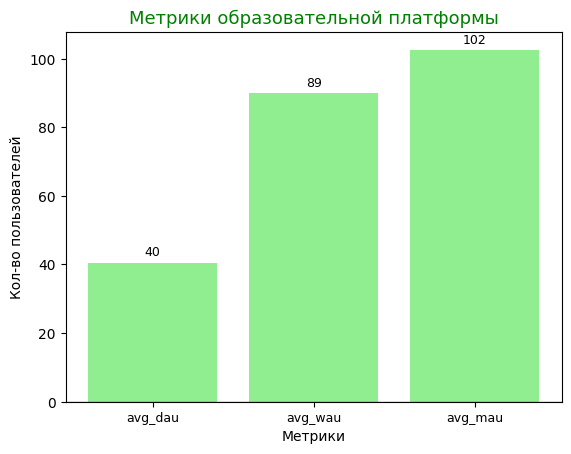

In [19]:
import os
from datetime import datetime

def metric(file_entry, file_registration):

    if not os.path.exists(file_entry) or not os.path.exists(file_registration):
        print(f"❌ Файл(ы) не найден(ы): {file_entry}")
        return None

    registrations = {} # Словарь регистраций
    entries_by_date = {}  # Словарь: дата - множество пользователей без дублей
    all_months = set() # Множество всех месяцев
    all_weeks = set()  # Множество всех недель
    all_days = set()   # Множество всех дней

    with open(file_registration, 'r', encoding='utf-8') as f:
        next(f)  # Пропуск заголовка
        for line in f:
            if line.strip():
                user_id, date_str = line.strip().split(';')
                date = datetime.strptime(date_str, '%Y-%m-%d')
                registrations[user_id] = date

    with open(file_entry, 'r', encoding='utf-8') as f:
        next(f)  # Пропуск заголовка
        for line in f:
            if line.strip():
                user_id, entry_date_str = line.strip().split(';')
                entry_date = datetime.strptime(entry_date_str, '%Y-%m-%d')

                if entry_date not in entries_by_date:  # {2023-01-01: {user_id....}}
                    entries_by_date[entry_date] = set()
                entries_by_date[entry_date].add(user_id)

                year_month = (entry_date.year, entry_date.month)  # Кортеж (год, месяц) {(2023, 1), (2023, 2), (2023, 3)}
                all_months.add(year_month)

                year_week = (entry_date.year, entry_date.isocalendar()[1])  # Кортеж (год, номер недели) {(2022, 52), (2023, 1),...}
                all_weeks.add(year_week)

                all_days.add(entry_date.date()) # { 2023-01-01, 2023-01-02,.. }

    mau_by_month = {}  # Словарь: месяц - множество уникальных пользователей

    for entry_date, users in entries_by_date.items():
        month_key = (entry_date.year, entry_date.month)
        if month_key not in mau_by_month:
            mau_by_month[month_key] = set()
        mau_by_month[month_key].update(users)  # Объединяем пользователей за месяц {(2023, 1): {user_id...}, ..}

    mau_values = [len(users) for users in mau_by_month.values()]
    avg_mau = sum(mau_values)/len(mau_values) if mau_values else 0   # Расчет среднего MAU

    wau_by_week = {}  # Словарь: неделя - множество уникальных пользователей
    for entry_date, users in entries_by_date.items():
        week_key = (entry_date.year, entry_date.isocalendar()[1])  # (год, номер недели)
        if week_key not in wau_by_week:
            wau_by_week[week_key] = set()
        wau_by_week[week_key].update(users)  # Объединяем пользователей за неделю {(2023, 52): {user_id...}, ..}

    wau_values = [len(users) for users in wau_by_week.values()]
    avg_wau = sum(wau_values)/len(wau_values) if wau_values else 0  # Расчет среднего WAU

    dau_values = [len(users) for users in entries_by_date.values()]
    avg_dau = sum(dau_values)/len(dau_values) if dau_values else 0 # Расчет метрик по дням (DAU)

    # Визуализация
    import pandas as pd
    import matplotlib.pyplot as plt
    df=pd.DataFrame({'metric':['avg_dau','avg_wau','avg_mau'],'value':[avg_dau,avg_wau,avg_mau]})
    plt.title('Метрики образовательной платформы',color='green',fontsize=13)
    plt.xlabel('Метрики',fontsize=10)
    plt.xticks(range(len(df)), df['metric'], rotation=0, fontsize=9)
    plt.ylabel('Кол-во пользователей',fontsize=10)
    [plt.text(i,v+max(df['value'])*0.01,f'{int(v):,}',ha='center',va='bottom', fontsize=9) for i,v in enumerate(df['value'])]
    plt.bar(range(len(df)), df['value'], color='lightgreen')
    plt.axhline(y=0, color='black', linewidth=1, linestyle='-', alpha=0.5)

    print(f" Усредененные метрики: \n AVG_MAU - {round(avg_mau, 5)},\n AVG_WAU - {round(avg_wau, 5)},\n AVG_DAU - {round(avg_dau, 5)} ")
    return round(avg_mau, 5), round(avg_wau, 5), round(avg_dau, 5)

metric('entries.csv', 'registrations.csv')